In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For i/o paths
from pathlib import Path

import m3code
import analysis
import models

# For manipulating lines
# from matplotlib.collections import LineCollection
import matplotlib.lines as mlines

# For manipulating colors
import matplotlib.colors as mcolors

import scipy.stats

In [2]:
from matplotlib import font_manager
import unicodedata

FONTS_DIR = 'ipaexg00401'
font_dirs = [FONTS_DIR]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for fpath in font_files:
    font_manager.fontManager.addfont(fpath)

plt.rcParams['font.family'] = ['sans-serif', 'serif', 'IPAexGothic']
plt.rcParams["font.sans-serif"] = ['Helvetica']
plt.rcParams['font.serif'] = ['Palatino']
SMALL_FONT_SIZE = 9
MEDIUM_FONT_SIZE = 11
LARGE_FONT_SIZE = 12.5
PANEL_LABEL_SIZE = 16
PANEL_LABEL_FONT = 'DejaVu Sans'
plt.rcParams.update({'font.size': MEDIUM_FONT_SIZE})

In [3]:
# Data paths
import json
data_dir = Path().resolve().parent / 'original' / 'selected_geotagged_tweet_data'
with (data_dir / 'file_names.json').open(mode='r') as f:
    file_names_dict = json.load(f)
all_file = data_dir / file_names_dict['all']['filename']

figdir = Path().resolve().parent / 'figure'

In [4]:
def plot_all_vs_keyword(ax, data_all, data_word, 
                        style='scatter', cmap='Blues', linecolor='#482475', nlevels=3):
    nonzero = data_word > 0
    data_all_nz = data_all[nonzero]
    data_word_nz = data_word[nonzero]
    if style == 'scatter':
        ax.scatter(data_all_nz, data_word_nz, s=1, c='k', marker='o', edgecolors='none', 
                    alpha=0.2, rasterized=True)
    elif style == 'contour':
        xmesh, ymesh, zmesh, dlevels = \
            models.data_contours(data_all_nz, data_word_nz, nlevels=nlevels, log_scale=True)
        fillcolors = plt.colormaps[cmap]
        ax.contourf(xmesh, ymesh, zmesh, 
            levels=np.append(dlevels, np.max(zmesh)), 
            colors=[fillcolors((i+1)/nlevels) for i in range(nlevels)], alpha=0.5)
        ax.contour(xmesh, ymesh, zmesh, 
                levels=np.append(dlevels, np.max(zmesh)), 
                colors=linecolor, alpha=0.5, linewidths=0.6)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(left=1, right=1E6)
    ax.set_ylim(bottom=0.8, top=5E4)

def scatter_plot_all_vs_keyword_empirical(ax, all_kw_df, kw_en):
    data_all = all_kw_df['tweetcount_all'].to_numpy()
    data_word = all_kw_df['tweetcount_' + kw_en].to_numpy()
    plot_all_vs_keyword(ax, data_all, data_word, style='scatter')
    ax.minorticks_off()

def contour_plot_all_vs_keyword_binomial(ax, all_kw_df, kw_en, rng, return_model=False, **params):
    data_all = all_kw_df['tweetcount_all'].to_numpy()
    data_word = all_kw_df['tweetcount_' + kw_en].to_numpy()
    plot_all_vs_keyword(ax, data_all, data_word, 
                        style='contour', cmap='Blues', linecolor='#482475')
    p_binomial = params['p_binomial']
    model_all, model_word = \
        models.random_data_from_model(data_all, p_binomial[kw_en], rng, num_repeat=5)
    plot_all_vs_keyword(ax, model_all, model_word, 
                        style='contour', cmap='Reds', linecolor='#D63230')
    ax.minorticks_off()

def contour_plot_all_vs_keyword_coreperi(ax, all_kw_df, kw_en, rng, return_model=False, **params):
    data_all = all_kw_df['tweetcount_all'].to_numpy()
    data_word = all_kw_df['tweetcount_' + kw_en].to_numpy()
    plot_all_vs_keyword(ax, data_all, data_word, 
                        style='contour', cmap='Blues', linecolor='#482475')
    distance = analysis.distance_from_center(all_kw_df, keyword=kw_en)
    near_p, radius, exponent = params['near_p'], params['radius'], params['exponent']
    p = models.core_periphery_model(distance, near_p[kw_en], radius[kw_en], exponent[kw_en])
    model_all, model_word = \
        models.random_data_from_model(data_all, p, rng, num_repeat=5)
    plot_all_vs_keyword(ax, model_all, model_word, 
                        style='contour', cmap='Reds', linecolor='#D63230')
    ax.minorticks_off()

def plot_all_vs_many_keywords(axes, all_kw_df, list_of_keywords, 
                              model='none', rng=None, with_jp=True, **params):
    for i, keywords in enumerate(list_of_keywords):
        for j, (keyword_jp, keyword_en) in enumerate(keywords):
            print('Processing:', keyword_en)
            if axes.ndim == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            if model == 'none':
                scatter_plot_all_vs_keyword_empirical(ax, all_kw_df, keyword_en)
            elif model == 'binomial':
                contour_plot_all_vs_keyword_binomial(ax, all_kw_df, keyword_en, rng, **params)
            elif model == 'coreperi':
                contour_plot_all_vs_keyword_coreperi(ax, all_kw_df, keyword_en, rng, **params)
            ax.text(0.07, 0.95, keyword_en, ha='left', va='top', 
                    transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)
            if with_jp:
                ax.text(0.07, 0.83, unicodedata.normalize('NFKC', keyword_jp), ha='left', va='top', 
                        transform=ax.transAxes, fontsize=MEDIUM_FONT_SIZE)
            
            if axes.ndim == 1 or i == len(axes) - 1:
                ax.set_xlabel(r'$n_\mathrm{all}$', labelpad=1)
            else:
                ax.set_xticklabels([])
            if j == 0:
                ax.set_ylabel(r'$n_w$', labelpad=1)
            else:
                ax.set_yticklabels([])
    return axes

def plot_all_vs_many_keywords2(fig, all_kw_df, dict_of_keywords, 
                               model='none', rng=None, with_jp=True, **params):
    subfigs = fig.subfigures(len(dict_of_keywords), 1, hspace=0.07, wspace=0)
    axes = []
    for i, (category, keywords) in enumerate(dict_of_keywords.items()):
        subfig = subfigs[i]
        subfig.text(-0.015, 0.5, category, ha='center', va='center', fontsize=LARGE_FONT_SIZE, rotation=90)
        axes.append(subfig.subplots(1, len(keywords)))
        for j, (keyword_jp, keyword_en) in enumerate(keywords):
            print('Processing', keyword_en)
            ax = axes[i][j]
            if model == 'none':
                scatter_plot_all_vs_keyword_empirical(ax, all_kw_df, keyword_en)
            elif model == 'binomial':
                contour_plot_all_vs_keyword_binomial(ax, all_kw_df, keyword_en, rng, **params)
            elif model == 'coreperi':
                contour_plot_all_vs_keyword_coreperi(ax, all_kw_df, keyword_en, rng, **params)
            ax.text(0.07, 0.95, keyword_en, ha='left', va='top', 
                    transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)
            if with_jp:
                ax.text(0.07, 0.83, unicodedata.normalize('NFKC', keyword_jp), ha='left', va='top', 
                        transform=ax.transAxes, fontsize=MEDIUM_FONT_SIZE)
            ax.tick_params(axis='both', which='major', labelsize=SMALL_FONT_SIZE, pad=0.5)
            ax.set_xlabel(r'$n_\mathrm{all}$', labelpad=-0.4)
            if j == 0:
                ax.set_ylabel(r'$n_w$', labelpad=0.8)
            else:
                ax.set_yticklabels([])
    return subfigs, axes

In [5]:
region_names = [('東北', 'Tohoku'), ('関東', 'Kanto'), ('東海','Tokai'), 
                ('関西', 'Kansai'), ('四国', 'Shikoku'), ('九州', 'Kyushu')]
pref_names = [('愛知', 'Aichi'), ('群馬', 'Gunma'), ('石川', 'Ishikawa'), 
              ('香川', 'Kagawa'), ('滋賀', 'Shiga'), ('宮城', 'Miyagi')]
city_names = [('京都', 'Kyoto'), ('名古屋', 'Nagoya'), ('福岡', 'Fukuoka'), 
              ('広島', 'Hiroshima'), ('仙台', 'Sendai'), ('札幌', 'Sapporo')]
ward_names = [('渋谷', 'Shibuya'), ('新宿', 'Shinjuku'), ('博多', 'Hakata'), 
              ('大宮', 'Omiya'), ('天王寺', 'Tennoji'), ('世田谷', 'Setagaya')]
nonsp_common_nouns = [('電話', 'telephone'), ('音楽', 'music'), ('野菜', 'vegetable'), 
                      ('社会', 'society'), ('財布', 'wallet'), ('理由', 'reason')]
sp_common_nouns = [('旅行', 'trip'), ('公園', 'park'),  ('大学', 'university'), 
                   ('ホテル', 'hotel'), ('空港', 'airport'), ('神社', 'shrine')]
foreign_toponyms = [('ハワイ', 'Hawaii'), ('ドバイ', 'Dubai'), ('ホンコン/香港', 'Hong Kong'), 
                    ('ニューヨーク', 'New York'), ('シンガポール', 'Singapore'),  ('ソウル', 'Seoul')]
list_of_keywords = region_names + pref_names + city_names + ward_names + \
    nonsp_common_nouns + sp_common_nouns + foreign_toponyms

In [6]:
# Load data
all_df = pd.read_csv(all_file, dtype={'m3code':str})
if not all_df['m3code'].is_unique:
    print('Total data: \"m3code\" is not unique.')
all_df[['latitude', 'longitude']] = m3code.latlon(all_df)

all_keyword_df = all_df.rename(columns={'tweetcount': 'tweetcount_all'})
for kw_jp, kw_en in list_of_keywords:
    kw_df = pd.read_csv(data_dir / file_names_dict[kw_en]['filename'], dtype={'m3code':str})
    if not kw_df['m3code'].is_unique:
        print(f'{kw_en} data: \"m3code\" is not unique.')
    all_keyword_df = pd.merge(all_keyword_df, kw_df[['m3code', 'tweetcount']], on='m3code', how='left')\
        .rename(columns={'tweetcount': 'tweetcount_' + kw_en})\
        .fillna(0)

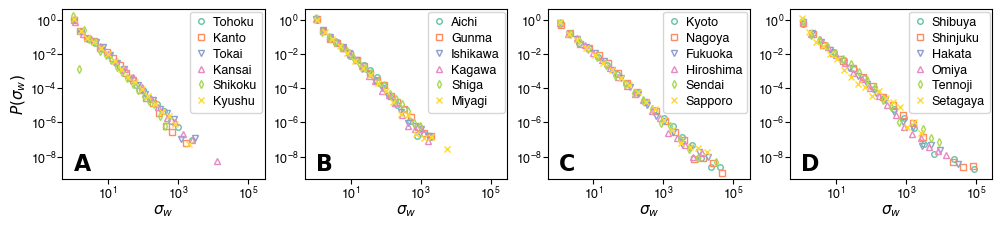

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(12, 2.2))
toponym_colors = plt.colormaps['Set2'](np.arange(6))
toponym_symbols = ['o', 's', 'v', '^', 'd', 'x']
for i, names in enumerate([region_names, pref_names, city_names, ward_names]):
    ax = axes[i]
    for j, (toponym_jp, toponym_en) in enumerate(names):
        densities = all_keyword_df['tweetcount_'+toponym_en].to_numpy() / all_keyword_df['area'].to_numpy()
        analysis.plot_single_histogram(
            ax, densities, numbins=18, xscale='log', yscale='log', discrete=False, 
            marker=toponym_symbols[j], ms=4, ls='', color=toponym_colors[j], mfc='none', mew=1, label=toponym_en)
    ax.minorticks_off()
    ax.tick_params(axis='both', which='major', labelsize=SMALL_FONT_SIZE, pad=1)
    ax.set_xlabel(r'$\sigma_w$', labelpad=0.5)
    if i == 0:
        ax.set_ylabel(r'$P(\sigma_w)$', labelpad=1.5)
    ax.legend(loc='upper right', fontsize=SMALL_FONT_SIZE,
              handlelength=0.9, handletextpad=0.5, borderaxespad=0.2, labelspacing=0.3)
    ax.set_xlim(left=0.5, right=3e5)
    ax.set_ylim(bottom=5e-10, top=4)
    ax.text(0.05, 0.05, r'$\bf{'+chr(65+i)+'}$', transform=ax.transAxes, fontsize=PANEL_LABEL_SIZE, 
            font=PANEL_LABEL_FONT, color='black')

In [8]:
fig.savefig(figdir / 'density_pdf_all_toponyms.pdf', bbox_inches='tight')

# Scatter plots

In [9]:
dict_of_keywords = {'Regions': region_names, 'Prefectures': pref_names, 
                    'Cities': city_names, 'Wards': ward_names, 
                    'Common nouns 1': nonsp_common_nouns,
                    'Common nouns 2': sp_common_nouns,
                    'Foreign places': foreign_toponyms}

Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya
Processing telephone
Processing music
Processing vegetable
Processing society
Processing wallet
Processing reason
Processing trip
Processing park
Processing university
Processing hotel
Processing airport
Processing shrine
Processing Hawaii
Processing Dubai
Processing Hong Kong
Processing New York
Processing Singapore
Processing Seoul


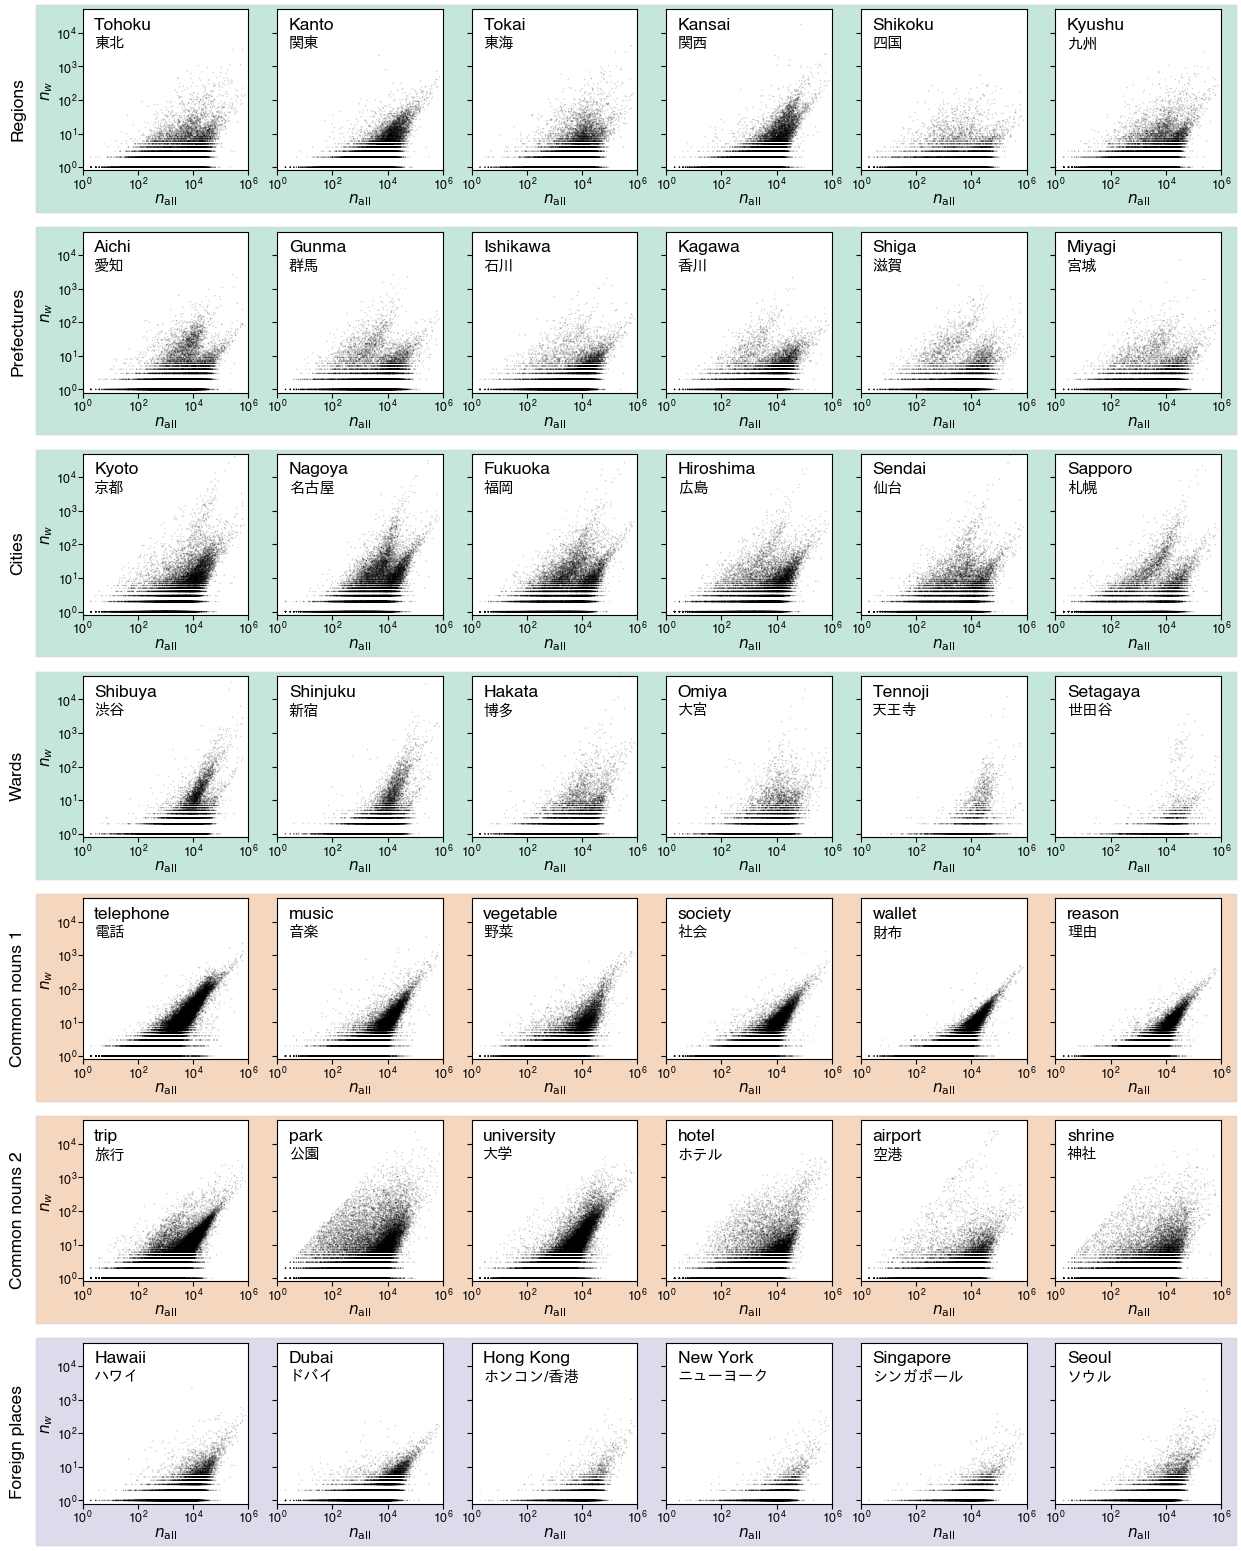

In [10]:
nrows = len(dict_of_keywords)
fig = plt.figure(figsize=(12, 2.2*nrows), layout='constrained')
subfigs, axes = plot_all_vs_many_keywords2(fig, all_keyword_df, dict_of_keywords, 
                                           model='none', with_jp=True)

bgcolors = plt.colormaps['Dark2'](np.array([0] * 4 + [1] * 2 + [2]))
for subfig, bgcolor in zip(subfigs, bgcolors):
    subfig.patch.set(facecolor=bgcolor, edgecolor='lightgrey', linewidth=1, alpha=0.25)

In [11]:
fig.savefig(figdir / 'all_tweets_vs_toponym_subsample_many.pdf', bbox_inches='tight')

# Models

## Location-independent model

In [12]:
rng = np.random.default_rng()

In [13]:
p_binomial = {}
aic_binomial = {}
bic_binomial = {}
for kws in dict_of_keywords.values():
    for _, keyword_en in kws:
        data_all = all_keyword_df['tweetcount_all'].to_numpy()
        data_word = all_keyword_df['tweetcount_' + keyword_en].to_numpy()
        p, aic, bic = models.binomial_mle(data_word, data_all)
        p_binomial[keyword_en] = p
        aic_binomial[keyword_en] = aic
        bic_binomial[keyword_en] = bic

Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya
Processing telephone
Processing music
Processing vegetable
Processing society
Processing wallet
Processing reason
Processing trip
Processing park
Processing university
Processing hotel
Processing airport
Processing shrine
Processing Hawaii
Processing Dubai
Processing Hong Kong
Processing New York
Processing Singapore
Processing Seoul


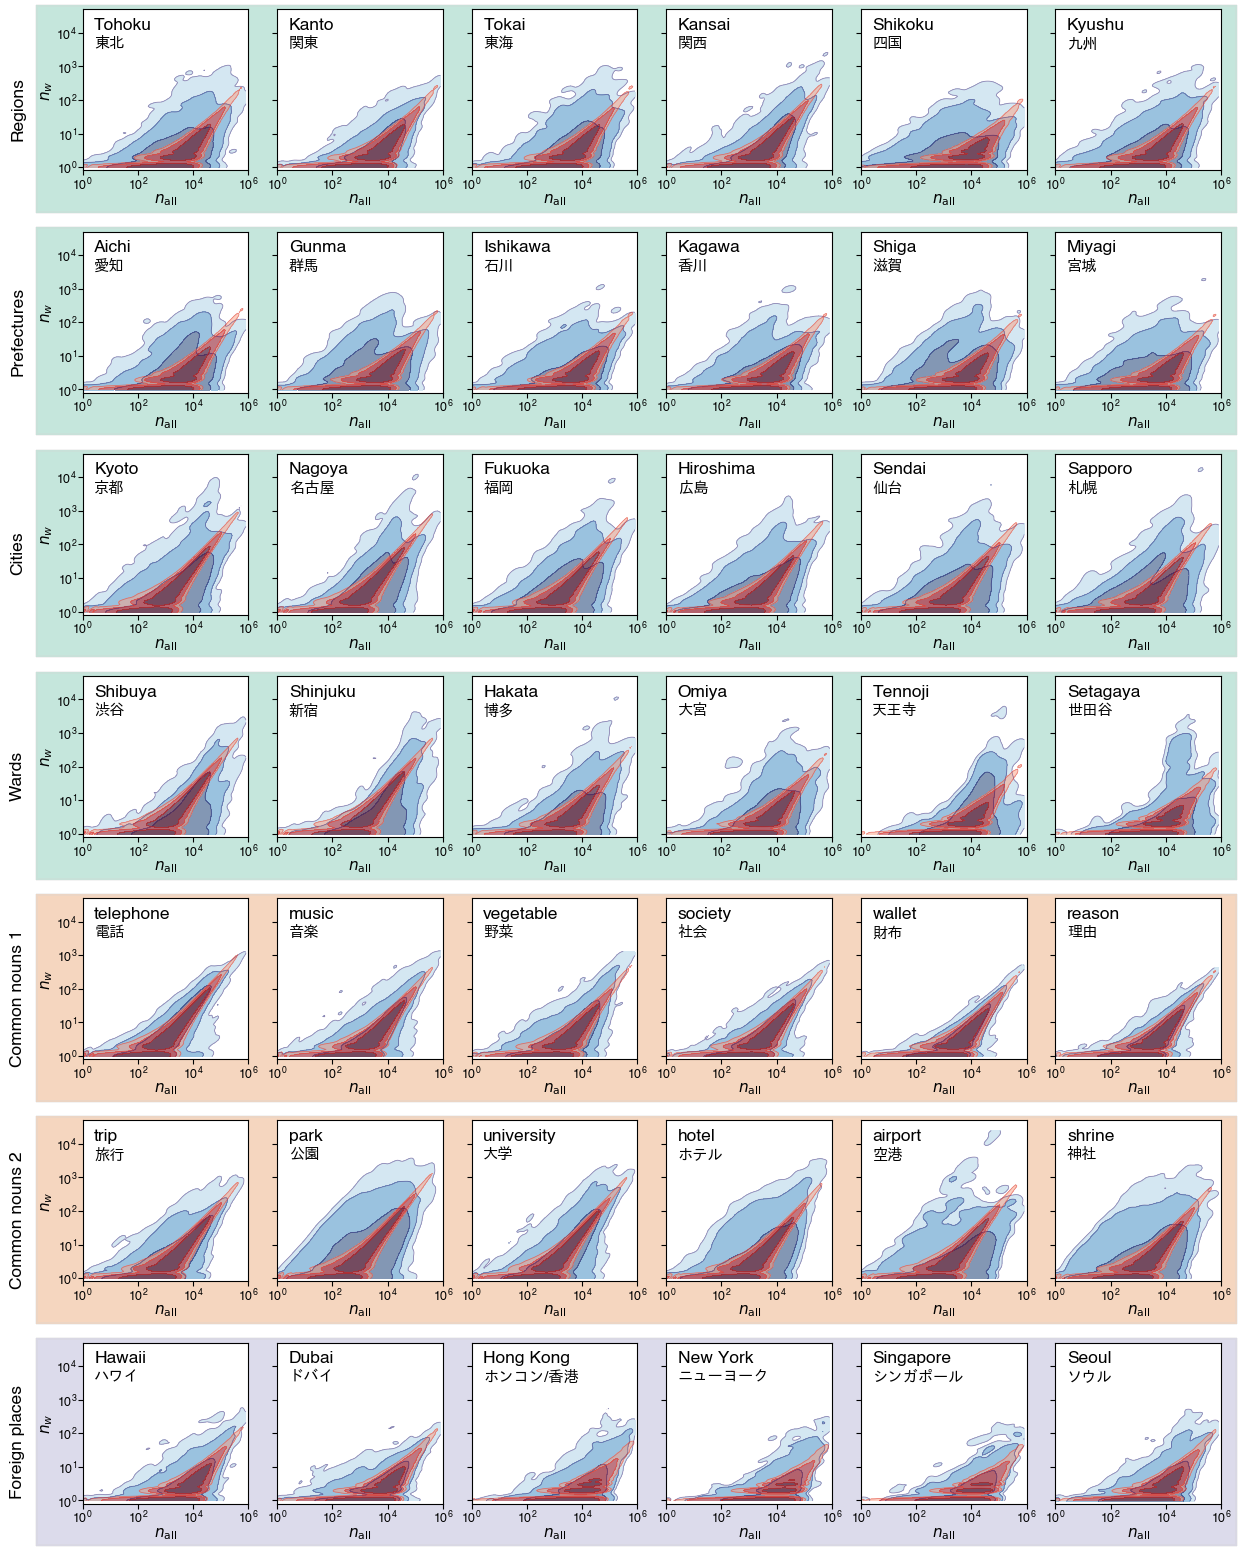

In [14]:
# Running this cell takes a few minutes
nrows = len(dict_of_keywords)
fig = plt.figure(figsize=(12, 2.2*nrows), layout='constrained')
subfigs, axes = plot_all_vs_many_keywords2(fig, all_keyword_df, dict_of_keywords, 
                                           model='binomial', rng=rng, p_binomial=p_binomial)
bgcolors = plt.colormaps['Dark2'](np.array([0] * 4 + [1] * 2 + [2]))
for subfig, bgcolor in zip(subfigs, bgcolors):
    subfig.patch.set(facecolor=bgcolor, edgecolor='lightgrey', linewidth=1, alpha=0.25)

In [15]:
fig.savefig(figdir / 'all_tweets_vs_toponym_subsample_many_binomial.pdf', bbox_inches='tight')

## Relative entropy

In [16]:
def entropy_empirical(sequence):
    counts = np.bincount(sequence)
    nonzero_counts = counts[counts > 0]
    probs = nonzero_counts / len(sequence)
    return -np.sum(probs * np.log(probs))

def entropy_binomial(sequence, n, p):
    likelihoods = scipy.stats.binom.pmf(sequence, n, p)
    likelihoods = np.where(likelihoods > 1e-20, likelihoods, 1e-20)
    return -np.sum(np.log(likelihoods)) / len(sequence)

# def KL_divergence_from_binomial(sequence, n, p):
#     return empirical_entropy_binomial(sequence, n, p) - empirical_entropy_empirical(sequence)

def KL_divergence_from_binomial(nums_word, nums_all):
    p = np.sum(nums_word) / np.sum(nums_all)
    kld = 0
    for n_all, counts in zip(*np.unique(nums_all, return_counts=True)):
        sequence = nums_word[nums_all == n_all].astype(int)
        kld += (entropy_binomial(sequence, n_all, p) - entropy_empirical(sequence)) * counts
    return kld / len(nums_all)

In [17]:
# Running this cell takes a few minutes
relative_entropy = {kw_en: [] for _, kw_en in list_of_keywords}
relative_entropy_nonzero = {kw_en: [] for _, kw_en in list_of_keywords}
for _, kw_en in list_of_keywords:
    print('Processing', kw_en)
    all_onekw_df = all_keyword_df[['tweetcount_all', 'tweetcount_'+kw_en]]
    all_onekw_nonzero_df = all_onekw_df[all_onekw_df['tweetcount_'+kw_en] > 0]
    for _ in range(50):
        nsample = 20000
        sample_df = all_onekw_df.sample(n=nsample, replace=True, random_state=rng)
        kld = KL_divergence_from_binomial(sample_df['tweetcount_'+kw_en].to_numpy(), 
                                          sample_df['tweetcount_all'].to_numpy())
        relative_entropy[kw_en].append(kld)

        nsample_nonzero = 3000
        sample_nonzero_df = all_onekw_nonzero_df.sample(n=nsample_nonzero, replace=True, random_state=rng)
        kld_nonzero = KL_divergence_from_binomial(sample_nonzero_df['tweetcount_'+kw_en].to_numpy(), 
                                                  sample_nonzero_df['tweetcount_all'].to_numpy())
        relative_entropy_nonzero[kw_en].append(kld_nonzero)

Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya
Processing telephone
Processing music
Processing vegetable
Processing society
Processing wallet
Processing reason
Processing trip
Processing park
Processing university
Processing hotel
Processing airport
Processing shrine
Processing Hawaii
Processing Dubai
Processing Hong Kong
Processing New York
Processing Singapore
Processing Seoul


In [18]:
jungle_green = mcolors.to_rgba_array('#19906C')
tea_green = mcolors.to_rgba_array('#D0F0C0')
green_shades = np.array([tea_green + (jungle_green - tea_green) * i / 3 for i in range(4)])
category_colors = [mcolors.to_hex(c) for c in green_shades]
print(category_colors)


['#d0f0c0', '#93d0a4', '#56b088', '#19906c']


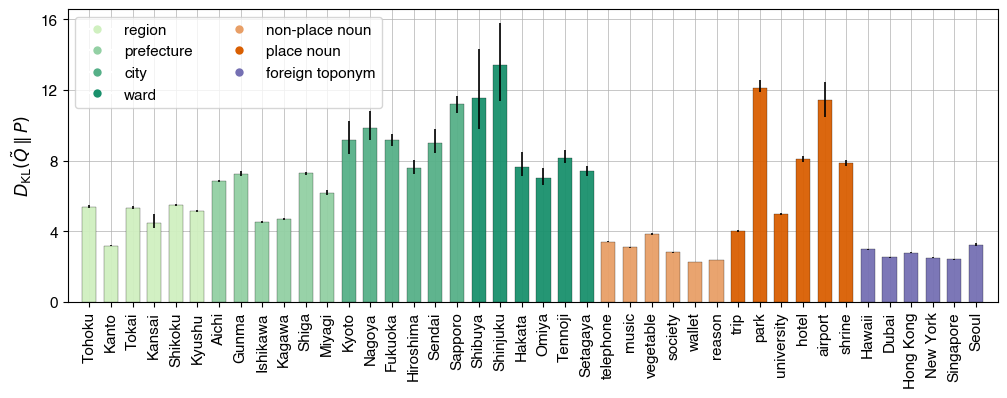

In [19]:
labels = [kw_en for _, kw_en in list_of_keywords]
klds = [relative_entropy_nonzero[label] for label in labels]
# colors = plt.colormaps['Dark2'](np.array([0] * 24 + [1] * 12 + [2] * 6))
unique_colors = category_colors + ['#e89f67', '#d95f02', '#7570b3']
colors = [c for c in unique_colors for _ in range(6)]


fig, ax = plt.subplots(figsize=(12, 3.8))
mean = np.mean(np.array(klds), axis=1)
ci_low, ci_high = scipy.stats.bootstrap((np.array(klds).T, ), np.mean,
                                        n_resamples=1000, confidence_level=0.95,
                                        random_state=rng).confidence_interval
xs = np.arange(1, len(labels) + 1)
ax.bar(xs, mean, color=colors, zorder=5, edgecolor='k', lw=0.2, width=0.65, alpha=0.95)
ax.vlines(xs, ci_low, ci_high, color='k', lw=1.2, zorder=5.1)
yticks = np.arange(0, np.max(ci_high)*1.05, 4)
ax.set_yticks(yticks)
ax.set_ylim(bottom=0)
ylabel = r'$D_\mathrm{KL}(\tilde{Q} \parallel P)$'
ax.set_ylabel(ylabel, fontsize=LARGE_FONT_SIZE)
ax.set_xticks(xs, labels=labels, rotation=90)
ax.set_xlim(0, len(labels)+1)
ax.grid(lw=0.5)
legend_handles = [mlines.Line2D([], [], color='white', marker='o',
                                mfc=unique_colors[i], mec='none', ms=6) for i in range(7)]
legend_labels = ['region', 'prefecture', 'city', 'ward', 'non-place noun', 'place noun', 'foreign toponym']
ax.legend(legend_handles, legend_labels, loc='upper left', ncols=2)

In [20]:
fig.savefig(figdir / 'nonzero_relative_entropy.pdf', bbox_inches='tight')

In [21]:
total_counts = {}
for _, keyword_en in list_of_keywords:
    total_count = all_keyword_df['tweetcount_' + keyword_en].sum()
    total_counts[keyword_en] = total_count
print('Minimum total count:', min(total_counts.values()))

Minimum total count: 17137.0


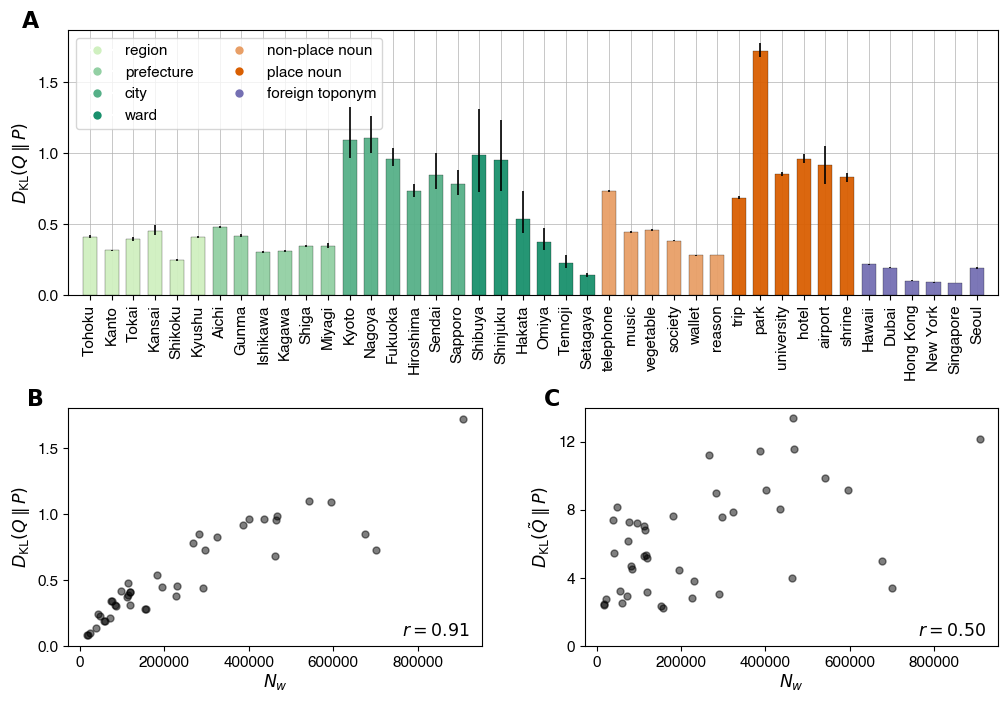

In [22]:
labels = [kw_en for _, kw_en in list_of_keywords]
# colors = plt.colormaps['Dark2'](np.array([0] * 24 + [1] * 12 + [2] * 6))
unique_colors = category_colors + ['#e89f67', '#d95f02', '#7570b3']
colors = [c for c in unique_colors for _ in range(6)]

fig = plt.figure(figsize=(12, 8))
ax_dict = fig.subplot_mosaic(
        """
        AA
        BC
        """, 
        height_ratios=[1, 0.9],
        gridspec_kw={'wspace': 0.25, 'hspace': 0.45}
        )

ax = ax_dict['A']
klds = [relative_entropy[label] for label in labels]
mean = np.mean(np.array(klds), axis=1)
ci_low, ci_high = scipy.stats.bootstrap((np.array(klds).T, ), np.mean,
                                        n_resamples=1000, confidence_level=0.95,
                                        random_state=rng).confidence_interval
xs = np.arange(1, len(labels) + 1)

ax.bar(xs, mean, color=colors, zorder=5, edgecolor='k', lw=0.2, width=0.65, alpha=0.95)
ax.vlines(xs, ci_low, ci_high, color='k', lw=1.2, zorder=5.1)
yticks = np.arange(0, np.max(ci_high)*1.05, 0.5)
ax.set_yticks(yticks)
ax.set_ylim(bottom=0)
ylabel = r'$D_\mathrm{KL}(Q \parallel P)$'
ax.set_ylabel(ylabel, fontsize=LARGE_FONT_SIZE)
ax.set_xticks(xs, labels=labels, rotation=90)
ax.set_xlim(0, len(labels)+1)
ax.grid(lw=0.5)
legend_handles = [mlines.Line2D([], [], color='white', marker='o',
                                mfc=unique_colors[i], mec='none', ms=6) for i in range(7)]
legend_labels = ['region', 'prefecture', 'city', 'ward', 'non-place noun', 'place noun', 'foreign toponym']
ax.legend(legend_handles, legend_labels, loc='upper left', ncols=2)
ax.text(-0.05, 0.99, 'A', ha='left', va='bottom', weight='bold',
        transform=ax.transAxes, font=PANEL_LABEL_FONT, fontsize=PANEL_LABEL_SIZE)

total_count_arr = [total_counts[label] for label in labels]

for i, rel_ent in enumerate([relative_entropy, relative_entropy_nonzero]):
    panel_label = 'B' if i == 0 else 'C'
    ylabel = r'$D_\mathrm{KL}(Q \parallel P)$' if i == 0 else r'$D_\mathrm{KL}(\tilde{Q} \parallel P)$'
    ytick_interval = 0.5 if i == 0 else 4

    ax = ax_dict[panel_label]
    klds = [rel_ent[label] for label in labels]
    mean = np.mean(np.array(klds), axis=1)
    ax.plot(total_count_arr, mean, 'o', ms=5, color='k', mec='k', mew=1, alpha=0.5)
    # Calculate correlation coefficient
    r, p = scipy.stats.pearsonr(total_count_arr, mean)
    ax.text(0.97, 0.03, f'$r = {r:.2f}$', ha='right', va='bottom', 
            transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)
    ax.set_xlabel(r'$N_w$', labelpad=1.5, fontsize=LARGE_FONT_SIZE)
    ax.set_ylim(bottom=0)
    ax.set_yticks(np.arange(0, np.max(mean)*1.05, ytick_interval))
    ax.set_ylabel(ylabel, fontsize=LARGE_FONT_SIZE)
    ax.text(-0.1, 0.99, panel_label, ha='left', va='bottom', weight='bold', 
            transform=ax.transAxes, font=PANEL_LABEL_FONT, fontsize=PANEL_LABEL_SIZE)

In [23]:
fig.savefig(figdir / 'relative_entropy_vs_total_count.pdf', bbox_inches='tight')

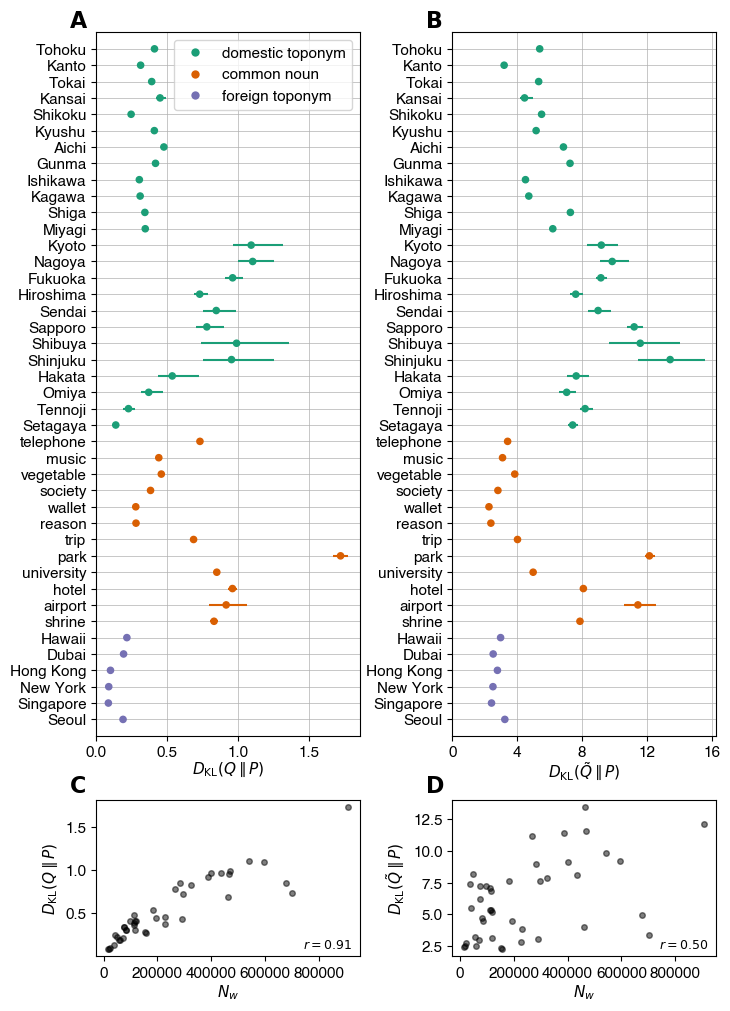

In [24]:
ncols = 2
labels, klds = zip(*relative_entropy.items())
klds_nonzero = [relative_entropy_nonzero[label] for label in labels]
total_count_arr = [total_counts[label] for label in labels]
colors = plt.colormaps['Dark2'](np.array([0] * 24 + [1] * 12 + [2] * 6))

fig, axes = plt.subplots(2, ncols, figsize=(4 * ncols, 12), 
                         gridspec_kw={'height_ratios': [4.5, 1], 'wspace': 0.35, 'hspace': 0.15})
panel_labels = np.array(list(map(chr, range(ord('A'), ord('A') + 2 * ncols)))).reshape(2, ncols)
for col in range(ncols):
    if col == 0:
        mean = np.mean(np.array(klds), axis=1)
        ci_low, ci_high = scipy.stats.bootstrap((np.array(klds).T, ), np.mean, 
                                                n_resamples=1000, confidence_level=0.95, 
                                                random_state=rng).confidence_interval
        xlabel = r'$D_\mathrm{KL}(Q \parallel P)$'
        xticks = None
    else:
        mean = np.mean(np.array(klds_nonzero), axis=1)
        ci_low, ci_high = scipy.stats.bootstrap((np.array(klds_nonzero).T, ), np.mean,
                                                n_resamples=1000, confidence_level=0.95,
                                                random_state=rng).confidence_interval
        xlabel = r'$D_\mathrm{KL}(\tilde{Q} \parallel P)$'
        xticks = np.arange(0, np.max(ci_high)*1.05, 4)
    ax = axes[0, col]
    ys = np.arange(len(labels), 0, -1)
    ax.scatter(mean, ys, color=colors, s=20, zorder=5)
    ax.hlines(ys, ci_low, ci_high, color=colors, lw=1.5, zorder=4.9)
    # ax.axvline(0, color='darkgrey', lw=2, zorder=2.1)
    ax.set_xlim(left=0)
    ax.set_yticks(ys, labels=labels)
    ax.grid(lw=0.5)
    ax.set_ylim(0, len(labels)+1)
    ax.set_xlabel(xlabel, labelpad=1)
    ax.text(-0.1, 1, panel_labels[0][col],
            ha='left', va='bottom', weight='bold', 
            transform=ax.transAxes, font=PANEL_LABEL_FONT, fontsize=PANEL_LABEL_SIZE)
    if col == 0:
        unique_colors = colors[[0, 24, 36]]
        ax.legend([mlines.Line2D([], [], color='white', marker='o', 
                                 mfc=unique_colors[i], mec='none', ms=6) for i in range(3)],
                   ['domestic toponym', 'common noun', 'foreign toponym'], loc='upper right')
    if xticks is not None:
        ax.set_xticks(xticks)

    ax = axes[1, col]
    ax.plot(total_count_arr, mean, 
            'o', ms=4, color='k', mec='k', mew=1, alpha=0.5)
    # Calculate correlation coefficient
    r, p = scipy.stats.pearsonr(total_count_arr, mean)
    ax.text(0.97, 0.03, f'$r = {r:.2f}$',
            ha='right', va='bottom', transform=ax.transAxes, fontsize=SMALL_FONT_SIZE)
    ax.set_xlabel(r'$N_w$', labelpad=1.5)
    ax.set_ylabel(xlabel)
    ax.text(-0.1, 1.02, panel_labels[1][col],
            ha='left', va='bottom', weight='bold', 
            transform=ax.transAxes, font=PANEL_LABEL_FONT, fontsize=PANEL_LABEL_SIZE)

## Core periphery model

In [25]:
toponym_categories = ['Regions', 'Prefectures', 'Cities', 'Wards']
dict_of_toponyms = {category: dict_of_keywords[category] for category in toponym_categories}

In [26]:
near_p = {}
radius = {}
exponent = {}
aic_coreperi = {}
bic_coreperi = {}

for kws in dict_of_toponyms.values():
    for _, keyword_en in kws:
        print('Processing', keyword_en)
        data_all = all_keyword_df['tweetcount_all'].to_numpy()
        data_word = all_keyword_df['tweetcount_' + keyword_en].to_numpy()
        distance = analysis.distance_from_center(all_keyword_df, keyword=keyword_en)
        params, aic, bic = \
            models.core_periphery_mle(data_word, data_all, distance)
        near_p[keyword_en] = params[0]
        radius[keyword_en] = params[1]
        exponent[keyword_en] = params[2]
        aic_coreperi[keyword_en] = aic
        bic_coreperi[keyword_en] = bic
        print(f'{keyword_en:<12} : near_p = {near_p[keyword_en]:.4f}, '
              f'radius = {radius[keyword_en]:<6.3g}, '
              f'exponent = {exponent[keyword_en]:.3f}')

Processing Tohoku
Tohoku       : near_p = 0.0025, radius = 83.7  , exponent = 1.589
Processing Kanto
Kanto        : near_p = 0.0007, radius = 62    , exponent = 0.500
Processing Tokai
Tokai        : near_p = 0.0003, radius = 268   , exponent = 1.162
Processing Kansai
Kansai       : near_p = 0.0013, radius = 60.4  , exponent = 0.747
Processing Shikoku
Shikoku      : near_p = 0.0027, radius = 16.4  , exponent = 1.223
Processing Kyushu
Kyushu       : near_p = 0.0020, radius = 66.1  , exponent = 1.072
Processing Aichi
Aichi        : near_p = 0.0029, radius = 20.6  , exponent = 1.220
Processing Gunma
Gunma        : near_p = 0.0083, radius = 10.7  , exponent = 1.500
Processing Ishikawa
Ishikawa     : near_p = 0.0067, radius = 11.2  , exponent = 1.107
Processing Kagawa
Kagawa       : near_p = 0.0129, radius = 3.53  , exponent = 0.957
Processing Shiga
Shiga        : near_p = 0.0104, radius = 6.24  , exponent = 1.406
Processing Miyagi
Miyagi       : near_p = 0.0048, radius = 29.7  , exponent = 

Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya


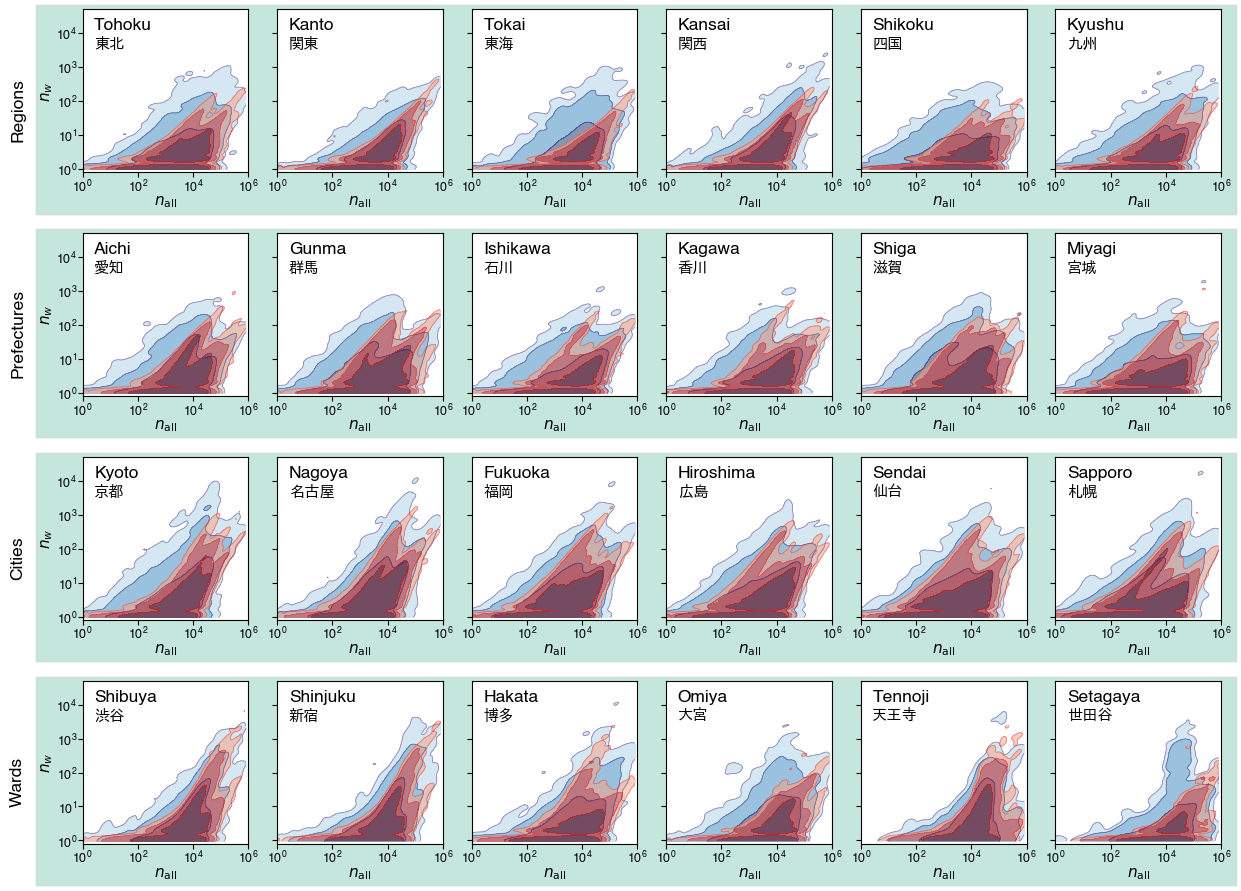

In [27]:
nrows = len(dict_of_toponyms)
fig = plt.figure(figsize=(12, 2.2*nrows), layout='constrained')
subfigs, axes = plot_all_vs_many_keywords2(fig, all_keyword_df, dict_of_toponyms,
                           model='coreperi', rng=rng, near_p=near_p, radius=radius, exponent=exponent)
bgcolors = plt.colormaps['Dark2'](np.array([0] * 4))
for subfig, bgcolor in zip(subfigs, bgcolors):
    subfig.patch.set(facecolor=bgcolor, edgecolor='lightgrey', linewidth=1, alpha=0.25)

In [28]:
fig.savefig(figdir / 'all_tweets_vs_toponym_subsample_many_coreperi.pdf', bbox_inches='tight')

## Summarize core-periphery model in one figure

In [29]:
# For map visualization
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import mapviz

In [30]:
def dms2dd(dms):
    '''Convert the degrees, minutes, seconds notation to decimal degrees'''
    return dms[0] + dms[1] / 60 + dms[2] / 3600

# Reachable extreme points of Japan
east_ext = dms2dd((145, 48, 58))
west_ext = dms2dd((122, 56, 1))
south_ext = dms2dd((24, 2, 59))
north_ext = dms2dd((45, 31, 22))

center_lon = dms2dd((139, 44, 28))
center_lat = dms2dd((35, 39, 29))
lon_diff = east_ext - west_ext
lat_diff = north_ext - south_ext
extent = (west_ext-lon_diff*0.05, east_ext+lon_diff*0.05, 
          south_ext-lat_diff*0.05, north_ext+lat_diff*0.05)

lambert_area_proj = ccrs.LambertAzimuthalEqualArea(
    central_longitude=center_lon, 
    central_latitude=center_lat)

In [31]:
# Get shapefiles of prefectures
shpfile_pref = shpreader.natural_earth(resolution='10m', category='cultural', 
                                       name='admin_1_states_provinces')
pref_shape_dict = {pref.attributes['name'].translate(str.maketrans({'Ō': 'O', 'ō' : 'o'})): pref.geometry 
                   for pref in shpreader.Reader(shpfile_pref).records()
                   if pref.attributes['admin'] == 'Japan'}

# Get shapefiles of metropolitan employment areas (MEAs)
mea_dir = Path().resolve().parent / 'original' / 'japan_MetropolitanEmploymentArea2015map'
shpfile_mea = mea_dir / 'japan_MetropolitanEmploymentArea2015map.shp'
mea_shape_dict = {mea.attributes['MEA_Name']: mea.geometry 
                  for mea in shpreader.Reader(shpfile_mea).records()}
print('Number of MEAs:', len(mea_shape_dict))

# The city name and MEA name is not exactly the same.
# Make a dictionary to convert city names to MEA names.
city_name_to_mea_name = {}
for city_jp, city_en in city_names:
    for mea_name in mea_shape_dict.keys():
        if city_en in mea_name:
            print(city_en, city_jp, mea_name)
            city_name_to_mea_name[city_en] = mea_name
city_shape_dict = {city_name: mea_shape_dict[mea_name] 
                   for city_name, mea_name in city_name_to_mea_name.items()}


Number of MEAs: 100
Kyoto 京都 Kyoto-Kusatsu
Nagoya 名古屋 Nagoya
Fukuoka 福岡 Fukuoka
Hiroshima 広島 Hiroshima
Sendai 仙台 Sendai
Sapporo 札幌 Sapporo-Otaru


Processing Tohoku
Processing Kanto
Processing Tokai
Processing Kansai
Processing Shikoku
Processing Kyushu
Processing Aichi
Processing Gunma
Processing Ishikawa
Processing Kagawa
Processing Shiga
Processing Miyagi
Processing Kyoto
Processing Nagoya
Processing Fukuoka
Processing Hiroshima
Processing Sendai
Processing Sapporo
Processing Shibuya
Processing Shinjuku
Processing Hakata
Processing Omiya
Processing Tennoji
Processing Setagaya
Processing Aichi
Radius: 20.58 km, Exponent: 1.22
Processing Gunma
Radius: 10.67 km, Exponent: 1.50
Processing Ishikawa
Radius: 11.18 km, Exponent: 1.11
Processing Kagawa
Radius: 3.53 km, Exponent: 0.96
Processing Shiga
Radius: 6.24 km, Exponent: 1.41
Processing Miyagi
Radius: 29.74 km, Exponent: 1.49
Processing Kyoto
Radius: 3.49 km, Exponent: 0.74
Processing Nagoya
Radius: 7.64 km, Exponent: 0.96
Processing Fukuoka
Radius: 24.74 km, Exponent: 1.17
Processing Hiroshima
Radius: 18.23 km, Exponent: 1.24
Processing Sendai
Radius: 24.14 km, Exponent: 1.55
Pr

Text(0.025, 0.96, 'D')

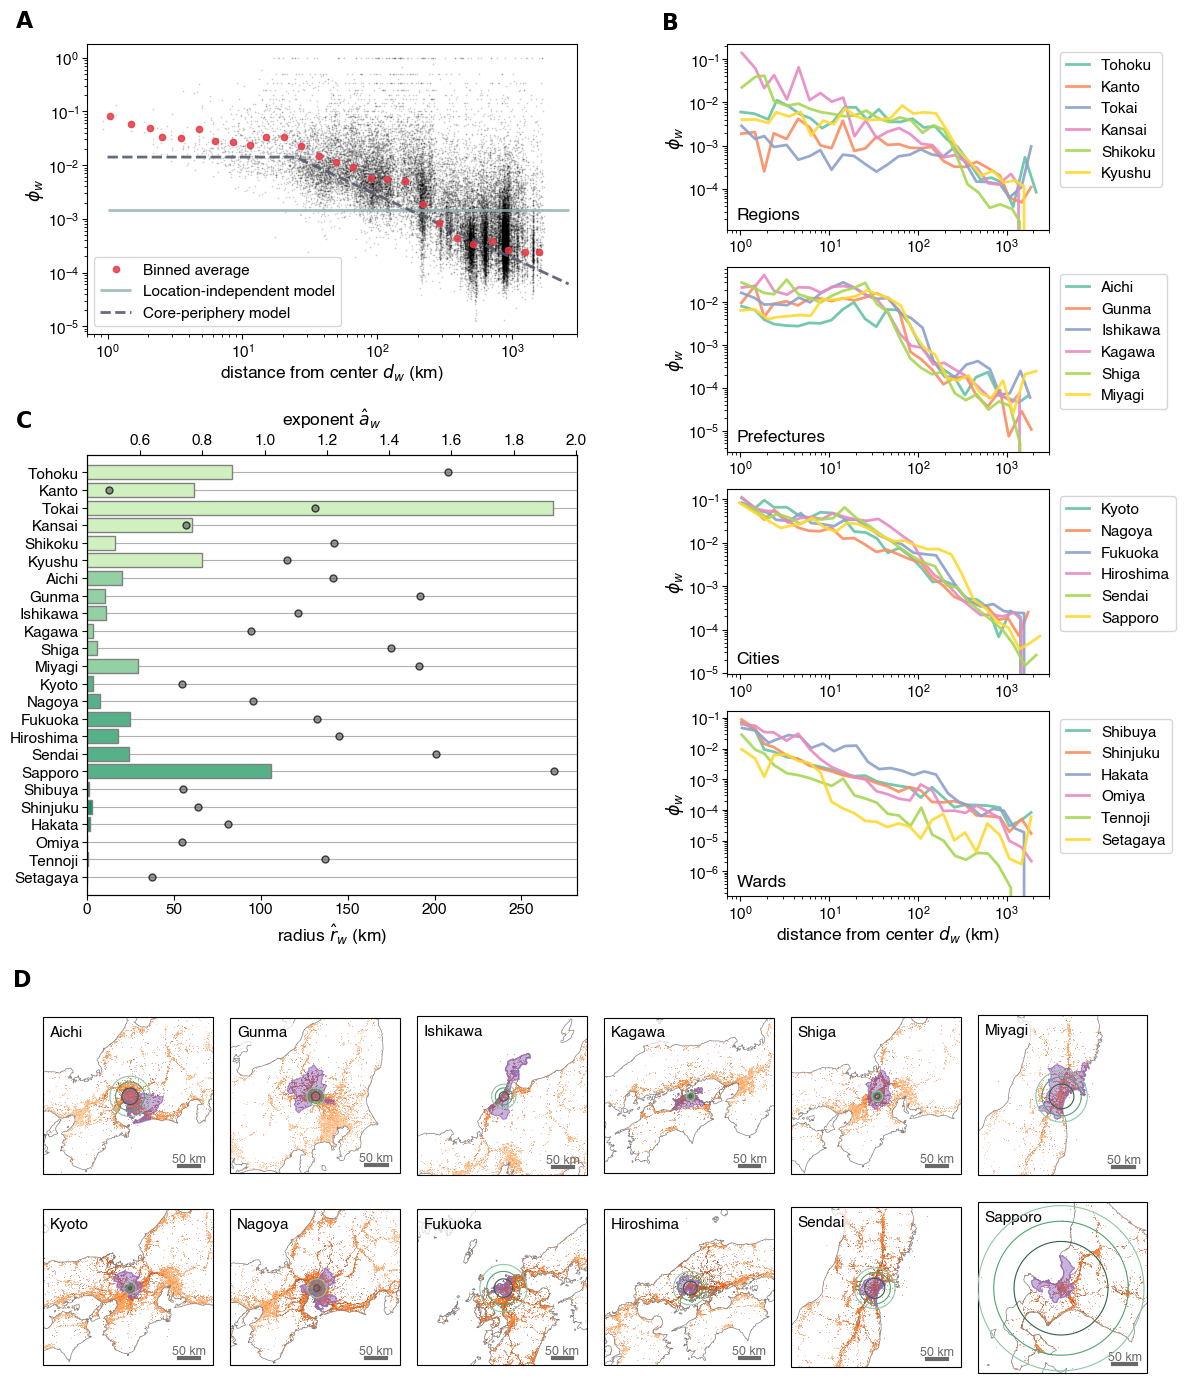

In [32]:
panel_label_kwargs = {'ha': 'left', 'va': 'bottom', 'weight': 'bold', 
                      'fontsize': PANEL_LABEL_SIZE, 'font': PANEL_LABEL_FONT}
colors = [c for c in category_colors for _ in range(6)]
lim_color = '#89b0ae'
cpm_color = '#555b6e'
toponym_colors = plt.colormaps['Set2'](np.arange(6))
big_toponym = 'Fukuoka'
tick_param_kwargs = {'axis': 'both', 'which': 'major', 'labelsize': MEDIUM_FONT_SIZE, 'pad': 2}
scale_bar_loc = (0.8, 0.05)
scale_bar_kwargs = dict(color='dimgrey', text_kwargs={'size': SMALL_FONT_SIZE})

fig = plt.figure(figsize=(12, 14))
subfig_ABC, subfig_D = fig.subfigures(2, 1, height_ratios=[1, 0.43])
subfig_AC, subfig_B = subfig_ABC.subfigures(1, 2, width_ratios=[1.2, 1], wspace=0.03)
subfig_A, subfig_C = subfig_AC.subfigures(2, 1, height_ratios=[1, 1.4])

big_toponym_ax = subfig_A.add_subplot()
axes_B = subfig_B.subplots(4, 1)
ax_rad = subfig_C.add_subplot()
axes_D = subfig_D.subplots(2, 6, subplot_kw=dict(projection=lambert_area_proj), 
                           gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

# Panel A/B
for i, category in enumerate(toponym_categories):
    names = dict_of_toponyms[category]
    ax = axes_B[i]
    ax.text(0.03, 0.04, category, transform=ax.transAxes, 
            ha='left', va='bottom', fontsize=LARGE_FONT_SIZE)
    for j, (toponym, toponym_en) in enumerate(names):
        print('Processing', toponym_en)
        data_all = all_keyword_df['tweetcount_all'].to_numpy()
        data_word = all_keyword_df['tweetcount_' + toponym_en].to_numpy()
        distance = analysis.distance_from_center(all_keyword_df, keyword=toponym_en)
        ratio = data_word / data_all
        
        logbins = np.geomspace(0.5, np.max(distance), 30)
        logbinned_distance = scipy.stats.binned_statistic(distance, distance, statistic='mean', bins=logbins).statistic
        logbinned_ratio = scipy.stats.binned_statistic(distance, ratio, statistic='mean', bins=logbins).statistic
        ax.plot(logbinned_distance, logbinned_ratio, '-', lw=2, alpha=0.9, color=toponym_colors[j], label=toponym_en)
        
        if toponym_en == big_toponym:
            big_toponym_ax.plot(distance, ratio, marker='o', ms=1.2, ls='', color='k', 
                    alpha=0.2, mec='none', rasterized=True)
            big_toponym_ax.plot(logbinned_distance, logbinned_ratio, marker='o', ms=4.5, ls='', lw=2, 
                    alpha=0.85, color='#e63946', zorder=2.5, label='Binned average')
            
            p_binom, aic_binom, bic_binom = models.binomial_mle(data_word, data_all)
            x_model = np.geomspace(1, np.max(distance), 200)
            y_model = models.core_periphery_model(x_model, near_p[big_toponym], radius[big_toponym], exponent[big_toponym])
            big_toponym_ax.hlines(p_binom, 1, np.max(distance), lw=2, color=lim_color, ls='-', 
                                  label='Location-independent model', alpha=0.8)
            big_toponym_ax.plot(x_model, y_model, lw=2, color=cpm_color, ls='--', 
                                label='Core-periphery model', alpha=0.9)
            big_toponym_ax.legend(loc='lower left', fontsize=MEDIUM_FONT_SIZE)

# Panel C
flatten_toponyms = [toponym_en for names in dict_of_toponyms.values() for _, toponym_en in names]
radius_arr = [radius[toponym_en] for toponym_en in flatten_toponyms]
ax_rad.barh(np.arange(len(radius_arr))[::-1], radius_arr, color=colors, edgecolor='grey', zorder=1.6)
ax_rad.set_yticks(np.arange(len(radius_arr))[::-1], flatten_toponyms)
ax_rad.grid(axis='y', zorder=0.9)
ax_rad.set_ylim(-1, len(radius_arr))

ax_exp = ax_rad.twiny()
exponent_arr = [exponent[toponym_en] for toponym_en in flatten_toponyms]
ax_exp.plot(exponent_arr, np.arange(len(exponent_arr))[::-1], 'o', 
            color='dimgrey', ms=5, mec='k', mew=1, alpha=0.7, zorder=1.1)

# Panel D
# shuffled_df = all_keyword_df.sample(frac=1, random_state=rng)
for i, (names, shape_dict) in enumerate(zip([pref_names, city_names], [pref_shape_dict, city_shape_dict])):
    for j, (_, toponym_en) in enumerate(names):
        print('Processing', toponym_en)
        print(f'Radius: {radius[toponym_en]:.2f} km, Exponent: {exponent[toponym_en]:.2f}')
        nonzero_df = all_keyword_df[all_keyword_df['tweetcount_' + toponym_en] > 0].sample(frac=1, random_state=rng)
        data_lon = nonzero_df['longitude'].to_numpy()
        data_lat = nonzero_df['latitude'].to_numpy()
        data_val = (nonzero_df['tweetcount_' + toponym_en] / nonzero_df['tweetcount_all']).to_numpy()
        norm = mcolors.LogNorm(vmax=np.quantile(data_val, 0.99))
        cmap = plt.get_cmap('Oranges', 8)
        center_latlon = analysis.center(nonzero_df, keyword=toponym_en)
        map_extent = (
            center_latlon[1]-lon_diff*0.1, 
            center_latlon[1]+lon_diff*0.1, 
            center_latlon[0]-lat_diff*0.08, 
            center_latlon[0]+lat_diff*0.08)
        ax = axes_D[i, j]
        map_data = mapviz.MapVisualizer(fig, extent=map_extent, projection=lambert_area_proj, 
                                        color='grey', resolution='10m', ax=ax, lw=0.5)
        map_data.visualize(data_lon, data_lat, data_val, cmap=cmap, norm=norm, 
                        size=0.4, marker=',', alpha=0.4, rasterized=True)
        toponym_text = map_data.ax.text(0.04, 0.95, toponym_en, ha='left', va='top',
                        transform=map_data.ax.transAxes, fontsize=MEDIUM_FONT_SIZE)
        toponym_text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none'))
        for factor, ec in zip([1, 2, 3], ['#2f6244', '#4ea472', '#8cc8a5']):
            map_data.add_circle(center_latlon[1], center_latlon[0],
                                radius[toponym_en] * 1000 * np.power(factor, 1 / exponent[toponym_en]),
                                fc='none', ec=ec, lw=0.8, zorder=4)
        shape = shape_dict[toponym_en]
        shape_feature = cfeature.ShapelyFeature(shape, ccrs.PlateCarree(), 
                                                fc=mcolors.to_rgba('tab:purple', 0.5), 
                                                ec=mcolors.to_rgba('tab:purple', 0.8), lw=0.8)
        map_data.ax.add_feature(shape_feature)
        mapviz.scale_bar(ax=map_data.ax, location=scale_bar_loc, length=50, 
                         **scale_bar_kwargs)

for ax in [big_toponym_ax] + axes_B.tolist():
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(r'$\phi_w$', labelpad=1.2, fontsize=LARGE_FONT_SIZE)
    ax.tick_params(**tick_param_kwargs)
    ax.set_xlim(left=0.7, right=3E3)

for ax in axes_B:
    ax.legend(loc='upper left', fontsize=MEDIUM_FONT_SIZE, bbox_to_anchor=(1.01, 1), handlelength=1.5)

for ax in [big_toponym_ax, axes_B[-1]]:
    ax.set_xlabel('distance from center ' + r'$d_w$ ' + '(km)', labelpad=0.9, fontsize=LARGE_FONT_SIZE)

ax_rad.set_xlabel('radius ' + r'$\hat{r}_w$ ' + '(km)', fontsize=LARGE_FONT_SIZE)
ax_rad.tick_params(**tick_param_kwargs)
ax_exp.set_xlabel('exponent ' + r'$\hat{a}_w$', fontsize=LARGE_FONT_SIZE, labelpad=6)
ax_exp.tick_params(**tick_param_kwargs)

# import matplotlib.patches as mpatches
# fig.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='k', fill=False, lw=1))
# subfig_A.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='b', fill=False, lw=1))
# subfig_C.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='r', fill=False, lw=1))
# subfig_B.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='g', fill=False, lw=1))
# subfig_D.add_artist(mpatches.Rectangle((0, 0), 1, 1, color='y', fill=False, lw=1))

subfig_A.subplots_adjust(top=0.88, bottom=0.17, left=0.16, right=0.92)
subfig_C.subplots_adjust(top=0.91, bottom=0.14, left=0.16, right=0.92)
subfig_B.subplots_adjust(top=0.95, bottom=0.08, left=0.15, right=0.75)
subfig_D.subplots_adjust(top=0.92, bottom=0.05, left=0.05, right=0.97)

subfig_A.text(0.05, 0.91, 'A', **panel_label_kwargs)
subfig_C.text(0.05, 0.95, 'C', **panel_label_kwargs)
subfig_B.text(0.03, 0.96, 'B', **panel_label_kwargs)
subfig_D.text(0.025, 0.96, 'D', **panel_label_kwargs)

In [33]:
fig.savefig(figdir / 'core_periphery.pdf', bbox_inches='tight')

## AIC comparison

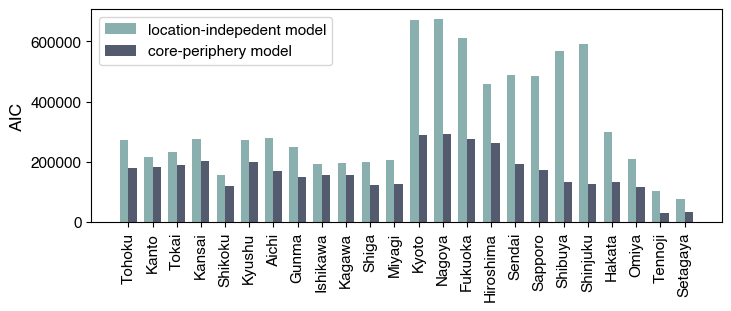

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7.2, 3), layout='constrained')
x = np.arange(len(aic_coreperi))
width = 0.35
multiplier = 0

lim_color = '#89b0ae' # '#2a9d8f' # '#BCA3CA' # '#a8dadc'
cpm_color = '#555b6e' # '#264653' # '#CCF0C3' # '#e63946'

toponyms_en = [toponym_en for names in dict_of_toponyms.values() for _, toponym_en in names]
ax.bar(x, [aic_binomial[toponym_en] for toponym_en in toponyms_en],
       width, label='location-indepedent model', color=lim_color)
ax.bar(x + width, [aic_coreperi[toponym_en] for toponym_en in toponyms_en],
       width, label='core-periphery model', color=cpm_color)
ax.set_xticks(x + width / 2, [toponym_en for toponym_en in toponyms_en], rotation=90)
ax.set_ylabel('AIC', fontsize=LARGE_FONT_SIZE)
ax.legend(fontsize=MEDIUM_FONT_SIZE)

In [35]:
fig.savefig(figdir / 'aic_comparison.pdf', bbox_inches='tight')

## Scatter plots for representative words

In [36]:
import matplotlib.patches as mpatches

4.000864864864865


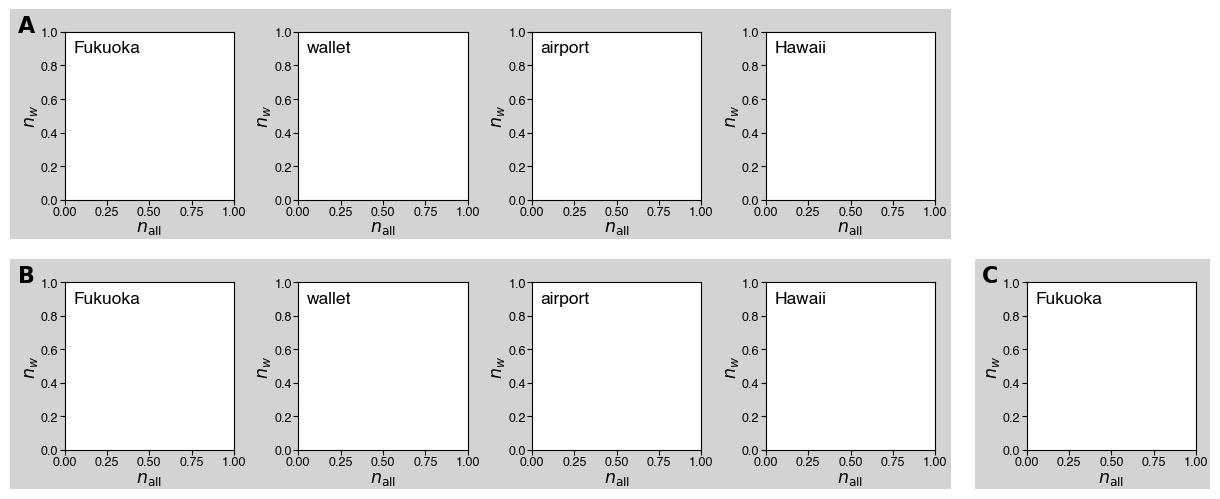

In [37]:
example_words = ['Fukuoka', 'wallet', 'airport', 'Hawaii']
example_word_coreperi = 'Fukuoka'

panel_label_kwargs = {'ha': 'left', 'va': 'top', 'weight': 'bold',
                      'fontsize': PANEL_LABEL_SIZE, 'font': PANEL_LABEL_FONT}

fig = plt.figure(figsize=(12, 4.8))
delta = 0.38
lr_A = 0.925
lr_B = 0.72
left_A = 0.058
left_B = 0.221
AB_width_ratio = (4 + 3 * delta) * lr_B / lr_A
print(AB_width_ratio)

subfigs_2x2 = fig.subfigures(2, 2, width_ratios=[AB_width_ratio, 1], wspace=0.04, hspace=0.09)
subfigs = [subfigs_2x2[0, 0], subfigs_2x2[1, 0], subfigs_2x2[1, 1]]
for subfig in subfigs:
    subfig.add_artist(mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgray', fill=True, 
                                         edgecolor='none', lw=1, zorder=0))

axes_scatter = subfigs[0].subplots(1, len(example_words), gridspec_kw={'wspace': delta})
axes_binomial = subfigs[1].subplots(1, len(example_words), gridspec_kw={'wspace': delta})
ax_coreperi = subfigs[2].add_subplot()

for subfig in [subfigs[0], subfigs[1]]:
    subfig.subplots_adjust(left=left_A, right=left_A+lr_A, top=0.9, bottom=0.17)
subfigs[2].subplots_adjust(left=left_B, right=left_B+lr_B, top=0.9, bottom=0.17)

for subfig, panel_label in zip(subfigs, ['A', 'B', 'C']):
    if panel_label == 'C':
        subfig.text(0.008 * AB_width_ratio, 0.98, panel_label, **panel_label_kwargs)
    else:
        subfig.text(0.008, 0.98, panel_label, **panel_label_kwargs)

for axes in [axes_scatter, axes_binomial]:
    for ax, word_en in zip(axes, example_words):
        ax.text(0.05, 0.95, word_en, ha='left', va='top',
                transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)

ax_coreperi.text(0.05, 0.95, example_word_coreperi, ha='left', va='top', 
                 transform=ax_coreperi.transAxes, fontsize=LARGE_FONT_SIZE)

for ax in axes_scatter.tolist() + axes_binomial.tolist() + [ax_coreperi]:
    ax.set_xlabel(r'$n_\mathrm{all}$', labelpad=1, fontsize=LARGE_FONT_SIZE)
    ax.set_ylabel(r'$n_w$', labelpad=0.8, fontsize=LARGE_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_FONT_SIZE, pad=1)

4.000864864864865


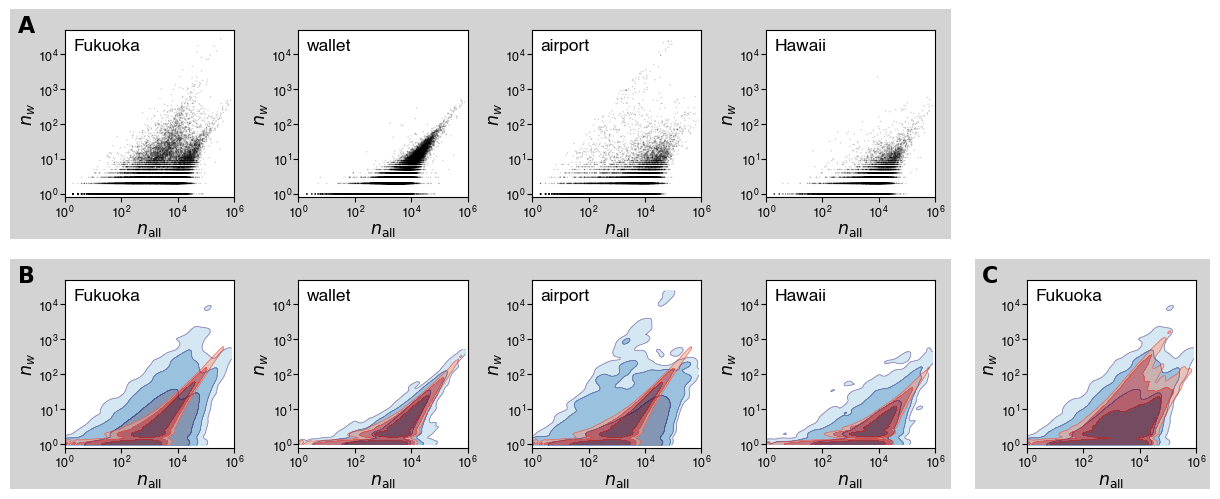

In [38]:
example_words = ['Fukuoka', 'wallet', 'airport', 'Hawaii']
example_word_coreperi = 'Fukuoka'

panel_label_kwargs = {'ha': 'left', 'va': 'top', 'weight': 'bold',
                      'fontsize': PANEL_LABEL_SIZE, 'font': PANEL_LABEL_FONT}

fig = plt.figure(figsize=(12, 4.8))
delta = 0.38
lr_A = 0.925
lr_B = 0.72
left_A = 0.058
left_B = 0.221
AB_width_ratio = (4 + 3 * delta) * lr_B / lr_A
print(AB_width_ratio)

subfigs_2x2 = fig.subfigures(2, 2, width_ratios=[AB_width_ratio, 1], wspace=0.04, hspace=0.09)
subfigs = [subfigs_2x2[0, 0], subfigs_2x2[1, 0], subfigs_2x2[1, 1]]
for subfig in subfigs:
    subfig.add_artist(mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgray', fill=True, 
                                         edgecolor='none', lw=1, zorder=0))

axes_scatter = subfigs[0].subplots(1, len(example_words), gridspec_kw={'wspace': delta})
axes_binomial = subfigs[1].subplots(1, len(example_words), gridspec_kw={'wspace': delta})
ax_coreperi = subfigs[2].add_subplot()

for subfig in [subfigs[0], subfigs[1]]:
    subfig.subplots_adjust(left=left_A, right=left_A+lr_A, top=0.91, bottom=0.18)
subfigs[2].subplots_adjust(left=left_B, right=left_B+lr_B, top=0.91, bottom=0.18)

for subfig, panel_label in zip(subfigs, ['A', 'B', 'C']):
    if panel_label == 'C':
        subfig.text(0.008 * AB_width_ratio, 0.98, panel_label, **panel_label_kwargs)
    else:
        subfig.text(0.008, 0.98, panel_label, **panel_label_kwargs)

for ax, kw in zip(axes_scatter, example_words):
    ax.text(0.05, 0.95, kw, ha='left', va='top',
            transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)
    scatter_plot_all_vs_keyword_empirical(ax, all_keyword_df, kw)
    
for ax, kw in zip(axes_binomial, example_words):
    ax.text(0.05, 0.95, kw, ha='left', va='top',
            transform=ax.transAxes, fontsize=LARGE_FONT_SIZE)
    
    contour_plot_all_vs_keyword_binomial(ax, all_keyword_df, kw, 
                                         rng=rng, p_binomial=p_binomial)

ax_coreperi.text(0.05, 0.95, example_word_coreperi, ha='left', va='top', 
                 transform=ax_coreperi.transAxes, fontsize=LARGE_FONT_SIZE)
contour_plot_all_vs_keyword_coreperi(ax_coreperi, all_keyword_df, example_word_coreperi, 
                                     rng=rng, near_p=near_p, radius=radius, exponent=exponent)

for ax in axes_scatter.tolist() + axes_binomial.tolist() + [ax_coreperi]:
    ax.set_xlabel(r'$n_\mathrm{all}$', labelpad=0.8, fontsize=LARGE_FONT_SIZE)
    ax.set_ylabel(r'$n_w$', labelpad=0.8, fontsize=LARGE_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_FONT_SIZE, pad=1)

In [39]:
fig.savefig(figdir / 'all_tweets_vs_toponym_subsample_example.pdf', bbox_inches='tight')